In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'rocket'})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_3/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
data_df.loc[0,['x1', 'x2', 'y1', 'y2', 'z1', 'z2']]

x1    11.0
x2    13.0
y1    12.0
y2    14.0
z1     9.0
z2    11.0
Name: 0, dtype: object

In [6]:
errors = compute_errors(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

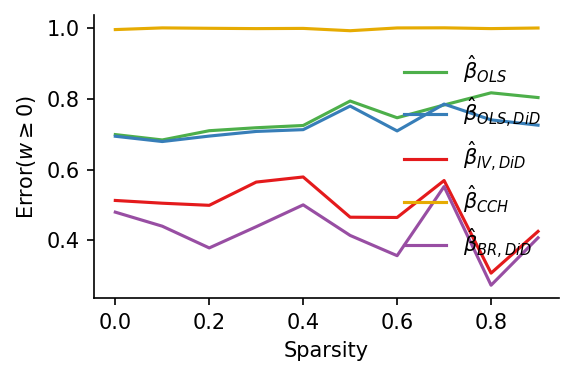

In [25]:
plot_errors(errors, 'sparsity', keys=['beta_ols', 'beta_ols_did', 'beta_iv_did', 'naive_cch', 'beta_brew_did'], save='sweep_3_error_sparsity')

In [8]:
error_trials = compute_error_trials(data_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
errors = compute_error_confidence(errors, error_trials)

In [11]:
errors[list(errors.keys())[0]][['sparsity', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

,sparsity,error_ols_iv_did_pval,error_ols_iv_did_statistic
0,0.2,3.896560e-18,0.0
1,0.1,3.896560e-18,0.0
2,0.9,3.896560e-18,0.0
3,0.7,3.896560e-18,0.0
4,0.6,3.896560e-18,0.0
5,0.5,3.896560e-18,0.0
6,0.8,3.896560e-18,0.0
7,0.0,3.896560e-18,0.0
8,0.4,3.896560e-18,0.0
9,0.3,3.896560e-18,0.0


In [12]:
errors[list(errors.keys())[0]][['sparsity', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

,sparsity,error_ols_iv_did_pval,error_ols_iv_did_statistic
0,0.2,3.896560e-18,0.0
1,0.1,3.896560e-18,0.0
2,0.9,3.896560e-18,0.0
3,0.7,3.896560e-18,0.0
4,0.6,3.896560e-18,0.0
5,0.5,3.896560e-18,0.0
6,0.8,3.896560e-18,0.0
7,0.0,3.896560e-18,0.0
8,0.4,3.896560e-18,0.0
9,0.3,3.896560e-18,0.0


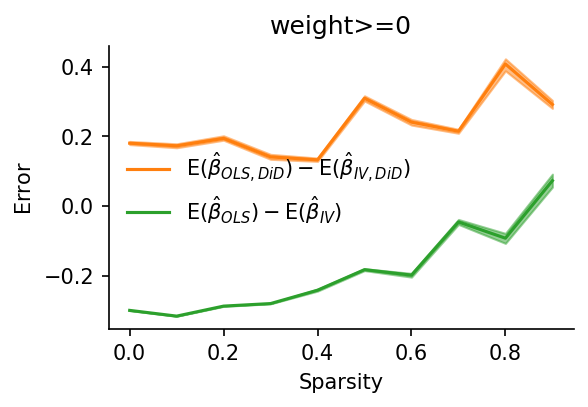

In [13]:
plot_error_difference(errors, 'sparsity')

# Convergence

In [14]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/8160 [00:00<?, ?it/s]

In [ ]:
error_convergence_trials = compute_error_convergence_trials(data_path)

  0%|          | 0/15000 [00:00<?, ?it/s]

/home/users/bjornmik/causal-optoconnectics/causal_optoconnectics/core.py:228: RuntimeWarning: invalid value encountered in true_divide
  y_refractory = np.divide(self.yz_sum, self.z_sum)
/home/users/bjornmik/causal-optoconnectics/causal_optoconnectics/core.py:230: RuntimeWarning: invalid value encountered in true_divide
  y_response_norefractory = np.divide(self.yzinv_sum, self.zinv_sum)
/home/users/bjornmik/causal-optoconnectics/causal_optoconnectics/core.py:232: RuntimeWarning: invalid value encountered in true_divide
  x_refractory = np.divide(self.xz_sum, self.z_sum) # this is set to zero and asserted below
/home/users/bjornmik/causal-optoconnectics/causal_optoconnectics/core.py:234: RuntimeWarning: invalid value encountered in true_divide
  x_response_norefractory = np.divide(self.xzinv_sum, self.zinv_sum)
/home/users/bjornmik/causal-optoconnectics/causal_optoconnectics/core.py:236: RuntimeWarning: invalid value encountered in true_divide
  y_response_spike = np.divide(self.yx_sum

In [ ]:
samples = compute_all_samples(data_path)

In [21]:
index = int(errors[list(errors.keys())[0]].query('sparsity==0.9').index.values)
index

2

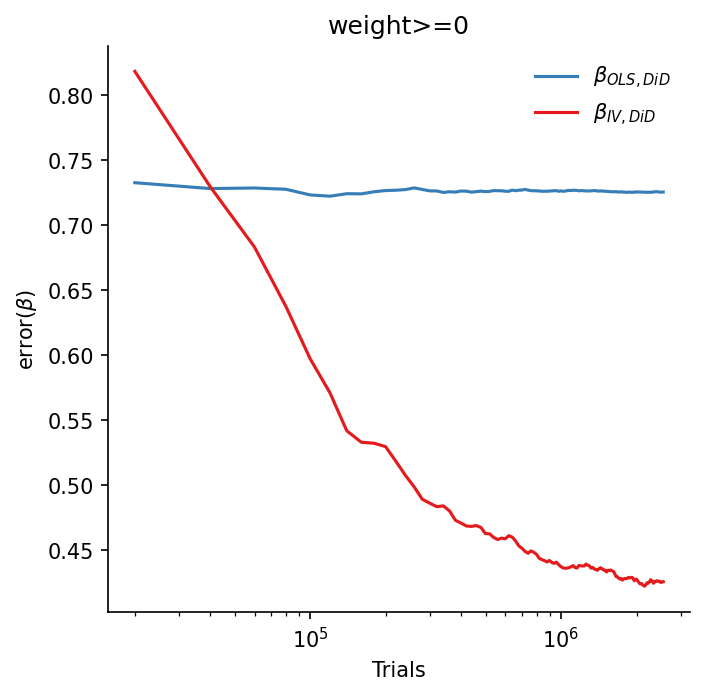

In [23]:
plot_error_convergence(error_convergence, index, ['beta_ols_did','beta_iv_did'])

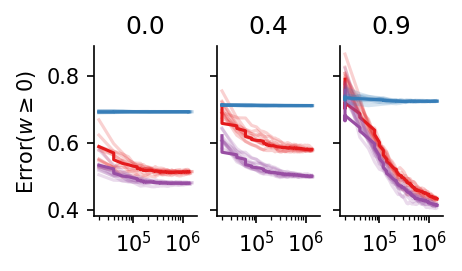

In [24]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey='row', figsize=(3,1.5), dpi=150)
for i, (sparsity, df) in enumerate(errors[list(errors.keys())[0]].query('sparsity in [0.0, 0.4, 0.9]').groupby('sparsity')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_iv_did', 'error_beta_brew_did', 'error_beta_ols_did'], 
        axs=[axs[i]], legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[i].set_title(f'{sparsity:.1f}')
savefig('sweep_3_sparsity_convergence')

# Regression

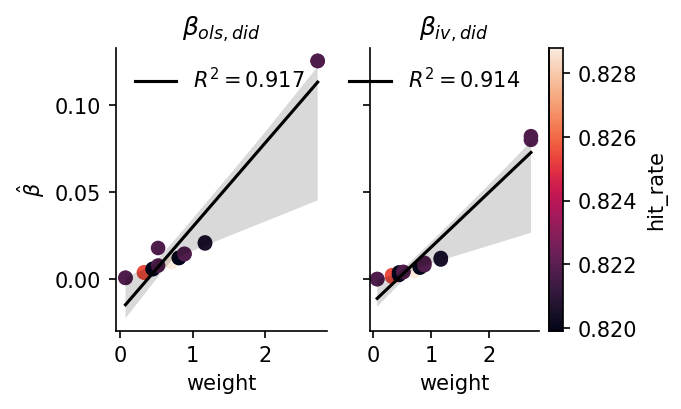

In [26]:
plot_regression(samples[index].query('weight > 0'), ['beta_ols_did','beta_iv_did'])

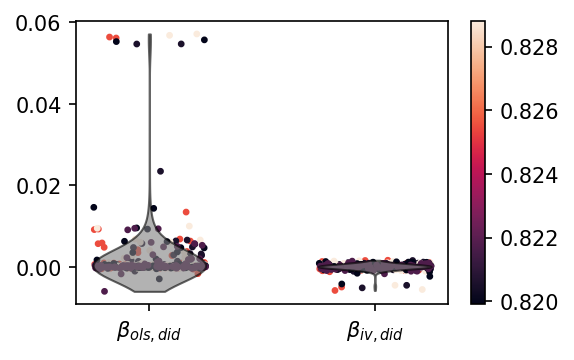

In [27]:
plot_false_positives(samples[index].query('weight == 0'), ['beta_ols_did', 'beta_iv_did'])

# Classification

In [28]:
keys = ['beta_ols_did', 'beta_iv_did', 'beta_brew_did', 'naive_cch']

In [29]:
auroc = []
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'sparsity': ser.sparsity,
            'group': key,
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

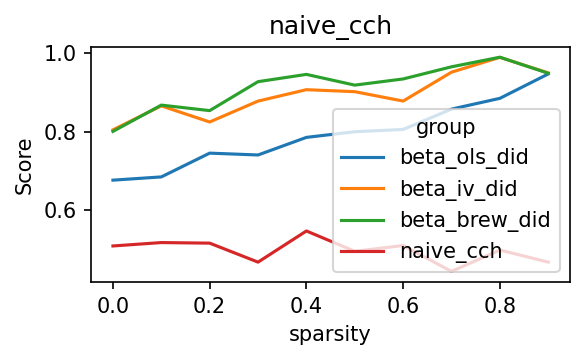

In [30]:
fig, ax = plt.subplots(1,1)
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="sparsity", y='auroc',
    hue="group",
    ax=ax
)
ax.set_ylabel('Score')
ax.set_title(key)
plt.tight_layout()